In [7]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.util.plotting_util import PlottingUtil

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPClassifier
# Train a decision tree classifier to predict 'tightest_bounds'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from simulation_engine.util.plotting_util import PlottingUtil
pd.options.mode.chained_assignment = None  # default='warn'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import re

#setup
results = pd.read_pickle('testrun.pkl')
# results = pd.read_pickle('../simulation_engine/results/binaryIV/06_06/12/results.pkl')
binaryIV = ContinuousIV('IV DAG', results)
ATE_algs = binaryIV.get_algorithms('ATE')
PNS_algs = binaryIV.get_algorithms('PNS')
algs = ATE_algs + PNS_algs
results


,seed,b_Z_X,b_U_X,b_X_Y,b_U_Y,p_Z,sigma_X,sigma_Y,sigma_U,g_U_X,g_U_Y,squash_X,squash_Y,g_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,Z,U,X,Y,Y_max,Y_min,X_max,X_min,X_mean,Y_mean,entropy_Z,entropy_X,ATE_zhangbareinboim_bound_lower,ATE_zhangbareinboim_bound_upper,ATE_zhangbareinboim_bound_valid,ATE_zhangbareinboim_bound_width,ATE_zhangbareinboim_bound_failed,ATE_causaloptim--binned_bound_lower,ATE_causaloptim--binned_bound_upper,ATE_causaloptim--binned_bound_valid,ATE_causaloptim--binned_bound_width,ATE_causaloptim--binned_bound_failed,ATE_autobound--binned_bound_lower,ATE_autobound--binned_bound_upper,ATE_autobound--binned_bound_valid,ATE_autobound--binned_bound_width,ATE_autobound--binned_bound_failed,ATE_zaffalonbounds--binned_bound_lower,ATE_zaffalonbounds--binned_bound_upper,ATE_zaffalonbounds--binned_bound_valid,ATE_zaffalonbounds--binned_bound_width,ATE_zaffalonbounds--binned_bound_failed,ATE_2SLS-0.99_bound_lower,ATE_2SLS-0.99_bound_upper,ATE_2SLS-0.99_bound_valid,ATE_2SLS-0.99_bound_width,ATE_2SLS-0.99_bound_failed,ATE_2SLS-0.98_bound_lower,ATE_2SLS-0.98_bound_upper,ATE_2SLS-0.98_bound_valid,ATE_2SLS-0.98_bound_width,ATE_2SLS-0.98_bound_failed,ATE_2SLS-0.95_bound_lower,ATE_2SLS-0.95_bound_upper,ATE_2SLS-0.95_bound_valid,ATE_2SLS-0.95_bound_width,ATE_2SLS-0.95_bound_failed,ATE_entropybounds-0.80--binned_bound_lower,ATE_entropybounds-0.80--binned_bound_upper,ATE_entropybounds-0.80--binned_bound_valid,ATE_entropybounds-0.80--binned_bound_width,ATE_entropybounds-0.80--binned_bound_failed,ATE_entropybounds-0.20--binned_bound_lower,ATE_entropybounds-0.20--binned_bound_upper,ATE_entropybounds-0.20--binned_bound_valid,ATE_entropybounds-0.20--binned_bound_width,ATE_entropybounds-0.20--binned_bound_failed,ATE_entropybounds-0.10--binned_bound_lower,ATE_entropybounds-0.10--binned_bound_upper,ATE_entropybounds-0.10--binned_bound_valid,ATE_entropybounds-0.10--binned_bound_width,ATE_entropybounds-0.10--binned_bound_failed
0,797607,-0.523175,-0.373105,-10.0,-1.024933,0.743490,0.824332,0.313681,0.258289,zero_centered_tanh,exp_clipped,tanh_scaled,tanh_scaled,bounded_linear,-2.772263e-01,0.000,0.119203,0.396429,"[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[-0.1380174642638321, 0.2751102095218106, -0.1...","[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, ...","[0.11920292202211757, 0.36950381760688183, 0.4...",0.501784,0.119203,1,0,0.382,0.290598,0.741483,0.959442,-0.542538,0.277956,True,0.820494,False,-0.169861,0.296685,False,0.466546,False,-0.346835,0.473659,True,0.820494,False,-0.0092,0.4527,False,0.4619,False,-0.348491,-0.241386,True,0.107105,False,-0.343305,-0.246573,True,0.096731,False,-0.335687,-0.254191,True,0.081497,False,-0.690996,0.277848,True,0.968845,False,-0.676167,-0.083265,True,0.592902,False,-0.635527,-0.232982,True,0.402545,False
1,258044,0.175339,-1.478720,-5.0,-1.481696,0.262553,0.834797,0.152564,1.851333,cos,rescaled_identity,tanh_scaled,probit,exp_clipped,-3.247651e-01,0.000,0.504485,0.829250,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, ...","[-0.8164831501823411, 1.4645054270982738, -1.0...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","[0.9668895670237231, 0.6473138311107421, 0.969...",0.999945,0.502688,1,0,0.464,0.682615,0.849943,0.996257,-0.669914,0.309216,True,0.979129,False,-0.502042,0.438866,True,0.940908,False,-1.000000,1.000000,True,2.000000,True,-0.4191,0.0091,True,0.4282,False,-1.000000,1.000000,True,2.000000,False,-1.000000,1.000000,True,2.000000,False,-1.000000,0.923786,True,1.923786,False,-0.229459,0.731996,False,0.961455,False,0.100592,0.708332,False,0.607740,False,0.236955,0.660054,False,0.423099,False
2,279349,1.193696,-0.602234,0.0,-0.554901,0.227834,0.774693,0.758535,0.255712,sigmoid_shifted,sigmoid,tanh_scaled,probit,rescaled_identity,0.000000e+00,0.000,0.447615,0.447615,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, ...","[0.432379643719818, -0.2737665600961133, 0.532...","[1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, ...","[0.38753897555656347, 0.26319193707112, 0.6418...",0.762158,0

                     Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
ATE_entropybounds-0.10--binned          0.00            60.00          0.5342      1.4137
    ATE_zaffalonbounds--binned          0.00            20.00          0.5497      0.8398
ATE_entropybounds-0.20--binned          0.00            40.00          0.6934      1.2160
                 ATE_2SLS-0.95          0.00            20.00          0.6983      0.9587
                 ATE_2SLS-0.98          0.00            20.00          0.7580      1.0064
                 ATE_2SLS-0.99          0.00            20.00          0.7857      1.0286
         ATE_autobound--binned         40.00             0.00          0.8037      1.2822
           ATE_zhangbareinboim          0.00             0.00          0.8173      0.8173
       ATE_causaloptim--binned          0.00            40.00          0.8439      1.3063
ATE_entropybounds-0.80--binned          0.00            20.00          0.9827      1.1862


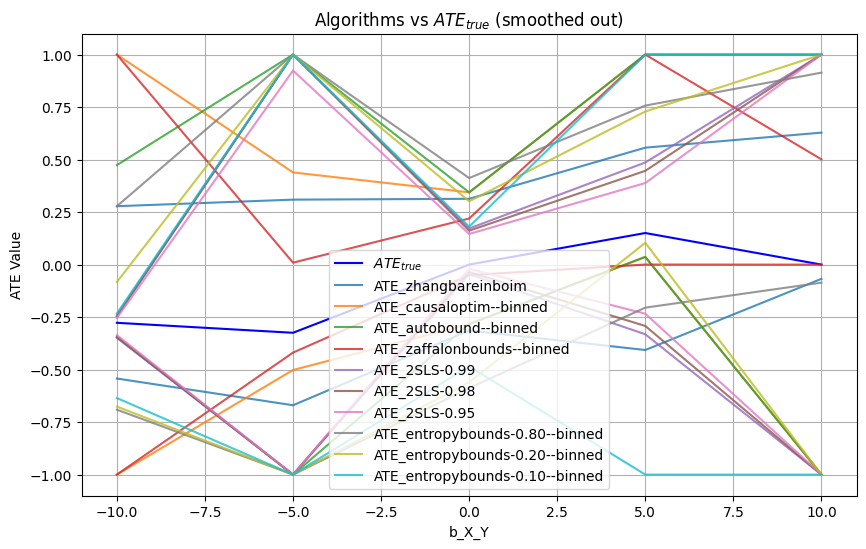

In [18]:
#ATE Evaluation
PlottingUtil.print_bound_statistics_table(results, algs, 'ATE')
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'ATE', ATE_algs, 1)

             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
           PNS_nonpara          0.00            27.55          0.1915      0.4142
    PNS_zaffalonbounds          0.00             1.50          0.3918      0.4009
       PNS_causaloptim          4.50            11.47          0.4106      0.5017
         PNS_autobound          1.20             1.47          0.4279      0.4431
PNS_entropybounds-0.10          0.00             0.25          0.5024      0.5036
PNS_entropybounds-0.20          0.00             0.10          0.5771      0.5775
PNS_entropybounds-0.80          0.00             0.10          0.7126      0.7129


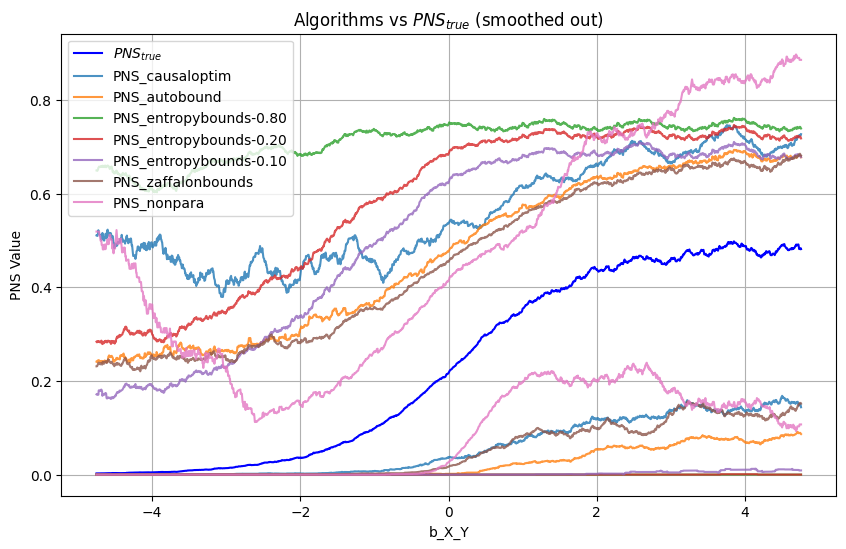

In [5]:
#PNS Evaluation
PlottingUtil.print_bound_statistics_table(results, algs, 'PNS')
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'PNS', PNS_algs, 100)

ATE algorithms: ['2SLS-0.99', '2SLS-0.98', 'causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']


d:\TUM Workspace\Thesis Workspace\causal-bounds\binaryIV\..\simulation_engine\util\plotting_util.py:233: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45, ha='right')


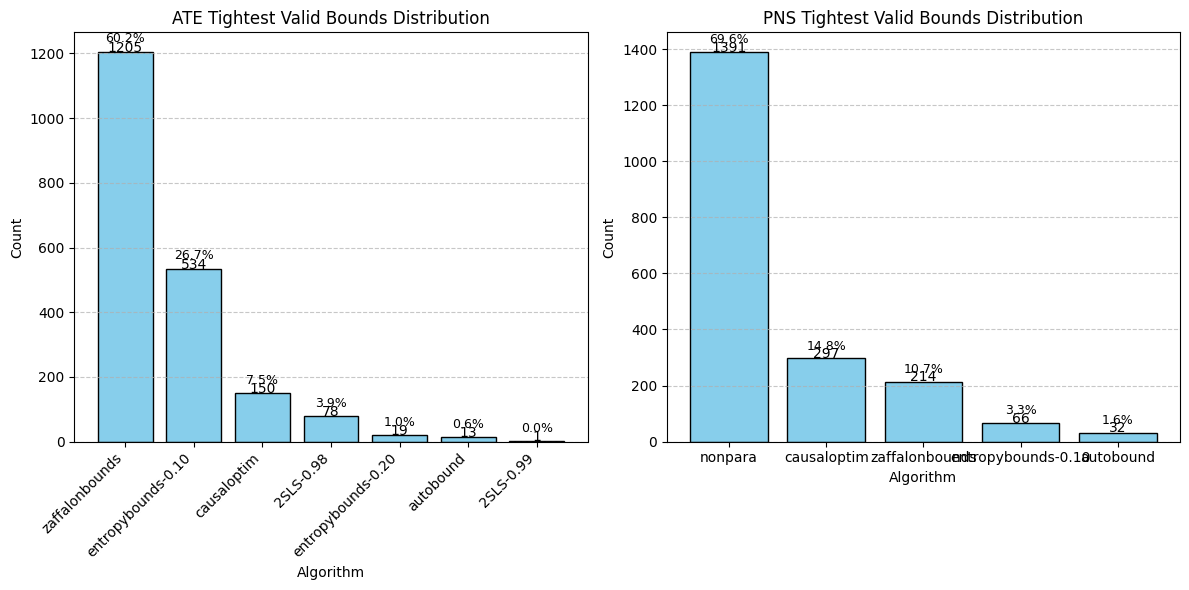

In [38]:
df = results.copy()
# Find tightest bounds without requiring bounds to be valid
tb = PlottingUtil.compute_tightest_bound_valid(df)
PlottingUtil.plot_tightest_bounds_distribution(tb, 'true')
